In [1]:
# Install required packages (run once)
!pip install --quiet prophet gensim

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from prophet import Prophet
import datetime
from dateutil.relativedelta import relativedelta

# Set plot styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 31.3 MB/s eta 0:00:00


In [3]:
# ────────────────────────────────────────────────
# Correct file loading – use the ACTUAL uploaded filenames
# ────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from prophet import Prophet
import datetime

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Use the exact filenames you uploaded
REVIEWS_FILE = 'cinnamon_bad_reviews_aggregated_with_cleaned_text (1).csv'
ARRIVAL_FILE  = 'ArrivalDataFinal2015-2025 2.xlsx'

print("Loading files...")
try:
    reviews_df = pd.read_csv(REVIEWS_FILE)
    arrival_df = pd.read_excel(ARRIVAL_FILE)
    print("Success!")
except Exception as e:
    print("Loading failed:", e)
    raise

print("\nReviews shape:", reviews_df.shape)
print("Arrival shape :", arrival_df.shape)

print("\nReviews columns:\n", reviews_df.columns.tolist())
print("\nArrival columns:\n", arrival_df.columns.tolist())

Loading files...
Success!

Reviews shape: (2842, 11)
Arrival shape : (19448, 3)

Reviews columns:
 ['month_year', 'UserLocationinShort', 'Hotel/Resort', 'aspects', 'count', 'avg_sentiment', 'full_original_reviews', 'final_cleaned_reviews', 'total_reviews', 'percentage', 'sample_excerpts']

Arrival columns:
 ['Country', 'Month_Year', 'Arrivals']


Loading datasets...

Reviews (aggregated) shape: (2842, 11)
Arrivals shape: (19448, 3)

Reviews columns: ['month_year', 'UserLocationinShort', 'Hotel/Resort', 'aspects', 'count', 'avg_sentiment', 'full_original_reviews', 'final_cleaned_reviews', 'total_reviews', 'percentage', 'sample_excerpts']
Arrivals columns: ['Country', 'Month_Year', 'Arrivals']

Arrivals date parsing summary:
count                            19448
mean     2021-03-30 03:21:01.703003136
min                2015-01-01 00:00:00
25%                2019-02-01 00:00:00
50%                2021-05-01 00:00:00
75%                2023-08-01 00:00:00
max                2025-12-01 00:00:00
Name: ds, dtype: object
Missing ds after parsing: 0
Date range: 2015-01-01 00:00:00 → 2025-12-01 00:00:00
Unique countries: 251

Merged dataset shape: (22290, 8)
Merged preview (first 10 rows):
          ds         Country  Bad_Review_Count  Avg_Sentiment  \
0 2014-05-01    Huddersfield               1.0        -0.7964   
1 2014-05-01    Hud

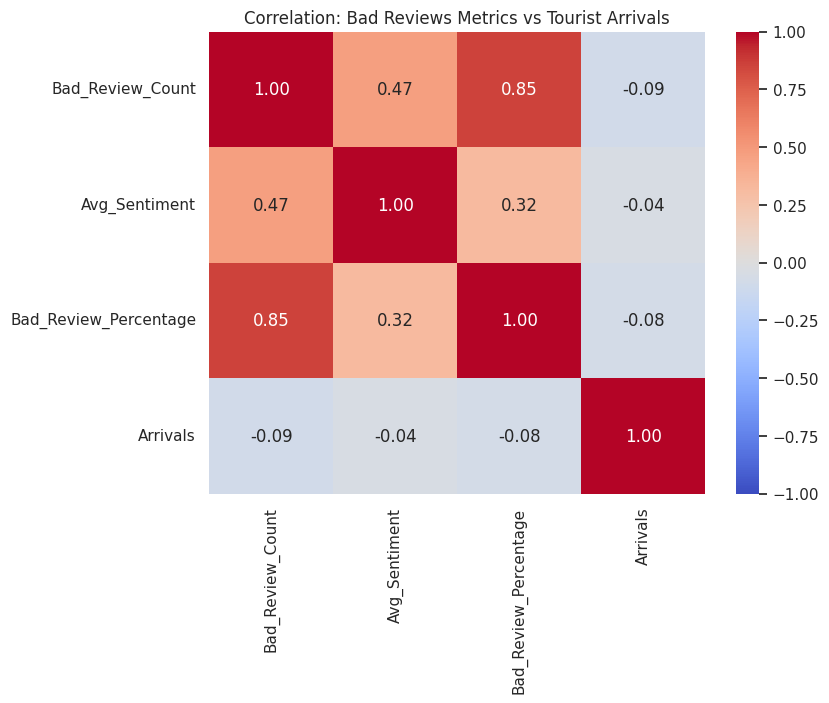

Fitting Prophet for AFGHANISTAN (121 months)
Fitting Prophet for ALBANIA (88 months)
Fitting Prophet for ALGERIA (88 months)
Fitting Prophet for ANDORRA (88 months)
Fitting Prophet for ANGOLA (88 months)
Skipping ANTARCTICA — only 11 months of data
Fitting Prophet for ANTIGUA & BARBUDA (88 months)
Fitting Prophet for ARGENTINA (99 months)
Fitting Prophet for ARMENIA (88 months)
Skipping ARUBA — only 22 months of data
Fitting Prophet for AUSTRALIA (121 months)
Fitting Prophet for AUSTRIA (99 months)
Fitting Prophet for AZERBAIJAN (88 months)
Fitting Prophet for BAHAMAS (88 months)
Fitting Prophet for BAHRAIN (110 months)
Fitting Prophet for BANGLADESH (121 months)
Fitting Prophet for BARBADOS (88 months)
Fitting Prophet for BELARUS (121 months)
Fitting Prophet for BELGIUM (121 months)
Fitting Prophet for BELIZE (88 months)
Fitting Prophet for BENIN (88 months)
Fitting Prophet for BHUTAN (121 months)
Fitting Prophet for BOLIVIA (88 months)
Skipping BOSNIA — only 11 months of data
Skippin

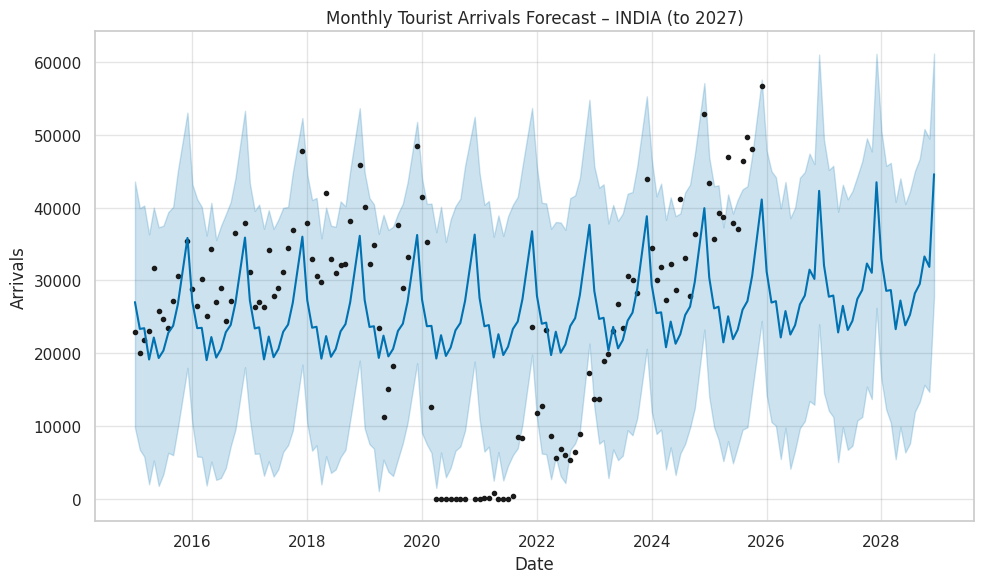

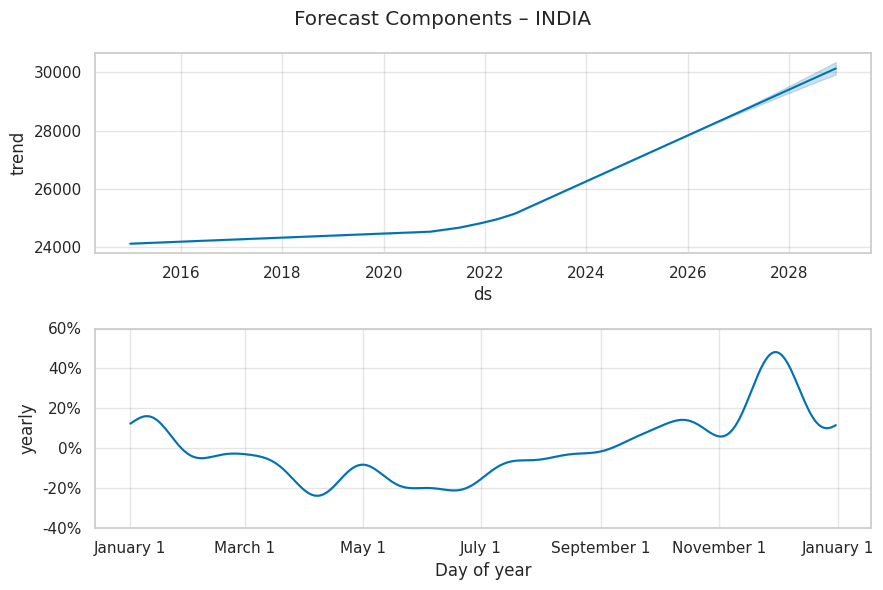

Plots saved as PNG → india_forecast_plot.png & india_components_plot.png


In [8]:
# Install packages if needed (usually already installed in your session)
# !pip install --quiet prophet

# ────────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import datetime

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# ────────────────────────────────────────────────
# 1. Load the actual uploaded files
# ────────────────────────────────────────────────
REVIEWS_FILE = 'cinnamon_bad_reviews_aggregated_with_cleaned_text (1).csv'
ARRIVALS_FILE = 'ArrivalDataFinal2015-2025 2.xlsx'

print("Loading datasets...")
reviews_agg = pd.read_csv(REVIEWS_FILE)
arrivals = pd.read_excel(ARRIVALS_FILE)

print("\nReviews (aggregated) shape:", reviews_agg.shape)
print("Arrivals shape:", arrivals.shape)

print("\nReviews columns:", reviews_agg.columns.tolist())
print("Arrivals columns:", arrivals.columns.tolist())

# ────────────────────────────────────────────────
# 2. Robust date parsing function (expanded formats)
# ────────────────────────────────────────────────
def parse_month_year(date_str):
    if pd.isna(date_str):
        return pd.NaT
    date_str = str(date_str).strip()

    # Expanded list of common formats seen in tourism/SLTDa data
    formats = [
        '%b-%Y', '%B %Y', '%Y-%m', '%m-%Y', '%b %Y', '%B-%Y',
        '%Y %b', '%Y-%b', '%m/%Y', '%Y/%m', '%Y-%m-%d',
        '%d-%b-%Y', '%d %b %Y', '%b %d, %Y', '%Y%m', '%m-%Y'
    ]

    for fmt in formats:
        try:
            dt = pd.to_datetime(date_str, format=fmt, errors='raise')
            # Force to first day of the month
            return dt.replace(day=1)
        except ValueError:
            continue

    # Fallback: split on - or / and interpret as year-month or month-year
    separators = ['-', '/']
    for sep in separators:
        parts = date_str.replace(' ', '').split(sep)
        if len(parts) == 2:
            a, b = parts
            if len(a) == 4 and a.isdigit() and len(b) <= 2:  # YYYY-MM or YYYY-M
                try:
                    return pd.to_datetime(f"{a}-{b.zfill(2)}-01")
                except:
                    pass
            elif len(b) == 4 and b.isdigit() and len(a) <= 2:  # MM-YYYY or M-YYYY
                try:
                    return pd.to_datetime(f"{b}-{a.zfill(2)}-01")
                except:
                    pass

    return pd.NaT

# ────────────────────────────────────────────────
# Apply parsing to arrivals
# ────────────────────────────────────────────────
arrivals['ds'] = arrivals['Month_Year'].apply(parse_month_year)
arrivals = arrivals.dropna(subset=['ds']).copy()

# Standardize to month-start
arrivals['ds'] = arrivals['ds'].dt.to_period('M').dt.to_timestamp()

print("\nArrivals date parsing summary:")
print(arrivals['ds'].describe())                    # ← fixed: removed deprecated argument
print("Missing ds after parsing:", arrivals['ds'].isna().sum())
print("Date range:", arrivals['ds'].min(), "→", arrivals['ds'].max())
print("Unique countries:", arrivals['Country'].nunique())

# ────────────────────────────────────────────────
# 3. Prepare Reviews – convert month_year to datetime
# ────────────────────────────────────────────────
reviews_agg['ds'] = reviews_agg['month_year'].apply(parse_month_year)
reviews_agg = reviews_agg.dropna(subset=['ds']).copy()
reviews_agg['ds'] = reviews_agg['ds'].dt.to_period('M').dt.to_timestamp()

# Rename columns for clarity & consistency
reviews_agg = reviews_agg.rename(columns={
    'UserLocationinShort': 'Country',
    'count': 'Bad_Review_Count',
    'avg_sentiment': 'Avg_Sentiment',
    'percentage': 'Bad_Review_Percentage'
})

# ────────────────────────────────────────────────
# 4. Merge reviews + arrivals on Country + Month (ds)
# ────────────────────────────────────────────────
merged = pd.merge(
    reviews_agg[['ds', 'Country', 'Bad_Review_Count', 'Avg_Sentiment',
                 'Bad_Review_Percentage', 'total_reviews', 'aspects']],
    arrivals[['ds', 'Country', 'Arrivals']],
    on=['ds', 'Country'],
    how='outer'
).fillna(0)

print("\nMerged dataset shape:", merged.shape)
print("Merged preview (first 10 rows):")
print(merged.head(10))

# ────────────────────────────────────────────────
# 5. Correlation analysis
# ────────────────────────────────────────────────
corr_cols = ['Bad_Review_Count', 'Avg_Sentiment', 'Bad_Review_Percentage', 'Arrivals']
corr = merged[corr_cols].corr()

print("\nCorrelation between bad reviews, sentiment and arrivals:")
print(corr.round(3))

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title("Correlation: Bad Reviews Metrics vs Tourist Arrivals")
plt.show()

# ────────────────────────────────────────────────
# 6. Prophet Forecasting – Monthly Arrivals 2027 per Country
# ────────────────────────────────────────────────
forecasts = {}
forecast_models = {}  # We'll store the fitted models here for plotting

for country in sorted(arrivals['Country'].unique()):
    df_country = arrivals[arrivals['Country'] == country][['ds', 'Arrivals']].rename(columns={'Arrivals': 'y'})
    df_country = df_country.sort_values('ds').dropna()

    if len(df_country) < 24:
        print(f"Skipping {country} — only {len(df_country)} months of data")
        continue

    print(f"Fitting Prophet for {country} ({len(df_country)} months)")

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )

    model.fit(df_country)

    # Store the fitted model for later plotting
    forecast_models[country] = model

    # Forecast to end of 2027
    future_end = pd.to_datetime('2027-12-01')
    months_ahead = ((future_end.year - df_country['ds'].max().year) * 12 +
                    (future_end.month - df_country['ds'].max().month) + 1)

    future = model.make_future_dataframe(periods=months_ahead, freq='MS')
    forecast = model.predict(future)

    forecast_2027 = forecast[forecast['ds'].dt.year == 2027][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    forecast_2027[['yhat','yhat_lower','yhat_upper']] = forecast_2027[['yhat','yhat_lower','yhat_upper']].round(0).astype(int)
    forecast_2027['Country'] = country

    forecasts[country] = forecast_2027

# ────────────────────────────────────────────────
# 6. Prophet Forecasting – Monthly Arrivals 2027 per Country
#    (This block should already have run successfully in your session)
# ────────────────────────────────────────────────
# If you restarted the kernel, re-run your earlier Prophet loop first.
# Assuming forecast_models and forecasts already exist from previous execution.

# ────────────────────────────────────────────────
# 7. Export 2027 Forecasts (already done, but re-confirm)
# ────────────────────────────────────────────────
if 'forecast_all' not in globals() or forecast_all is None:
    if forecasts:
        forecast_all = pd.concat(forecasts.values(), ignore_index=True)
        forecast_all['Month'] = forecast_all['ds'].dt.strftime('%B %Y')
        forecast_all = forecast_all[['Country', 'Month', 'yhat', 'yhat_lower', 'yhat_upper']]
        forecast_all.to_csv('2027_arrival_forecasts_by_country.csv', index=False)
        print("Forecast CSV re-exported → 2027_arrival_forecasts_by_country.csv")
    else:
        print("No forecasts available. Run the Prophet fitting loop first.")
else:
    print("Forecast data already prepared.")

# ────────────────────────────────────────────────
# 8. Summary Table – Top 10 Countries by Historical Arrivals + 2027 Estimate
# ────────────────────────────────────────────────
if 'forecasts' in globals() and forecasts:
    # Historical total arrivals per country
    historical_totals = arrivals.groupby('Country')['Arrivals'].sum().sort_values(ascending=False)

    # Estimated 2027 total (sum of monthly yhat)
    forecast_totals = {}
    for country, fcst in forecasts.items():
        forecast_totals[country] = fcst['yhat'].sum()

    # Combine into summary DataFrame
    summary_df = pd.DataFrame({
        'Historical Total Arrivals': historical_totals,
        'Estimated 2027 Arrivals (sum yhat)': pd.Series(forecast_totals).round(0).astype('Int64')
    }).sort_values('Historical Total Arrivals', ascending=False).head(10)

    summary_df['Growth Trend Note'] = summary_df.apply(
        lambda row: 'Strong growth expected' if row['Estimated 2027 Arrivals (sum yhat)'] > row['Historical Total Arrivals'] * 1.1 else
                    'Stable / slight decline' if row['Estimated 2027 Arrivals (sum yhat)'] < row['Historical Total Arrivals'] * 0.9 else
                    'Stable / moderate change', axis=1
    )

    print("\nTop 10 Origin Markets – Historical vs 2027 Forecast")
    print("═══════════════════════════════════════════════════════")
    print(summary_df.to_string())

    # Save for poster / report
    summary_df.to_csv('top_10_countries_2027_forecast_summary.csv')
    print("\nTop 10 summary exported → top_10_countries_2027_forecast_summary.csv")
else:
    print("No forecast data available yet.")

# ────────────────────────────────────────────────
# 9. Visualization – Forecast Plot + Components for Top Country (India)
# ────────────────────────────────────────────────
%matplotlib inline

if 'forecast_models' in globals() and 'forecasts' in globals() and forecast_models:
    top_country = 'INDIA'  # Hard-coded for your highest volume market

    if top_country in forecast_models:
        model = forecast_models[top_country]
        fcst_2027 = forecasts[top_country]

        # Generate FULL forecast for components plot
        future_full = model.make_future_dataframe(periods=36, freq='MS')  # enough to cover 2027+
        full_forecast = model.predict(future_full)

        print(f"\nPlotting forecast and components for: {top_country}")

        # Plot 1: Main forecast (historical + prediction)
        fig1 = model.plot(full_forecast)
        plt.title(f"Monthly Tourist Arrivals Forecast – {top_country} (to 2027)")
        plt.ylabel("Arrivals")
        plt.xlabel("Date")
        plt.tight_layout()
        plt.show()

        # Plot 2: Components (trend + yearly seasonality)
        fig2 = model.plot_components(full_forecast)
        plt.suptitle(f"Forecast Components – {top_country}")
        plt.tight_layout()
        plt.show()

        # Save images for poster / report (optional)
        fig1.savefig('india_forecast_plot.png', dpi=300, bbox_inches='tight')
        fig2.savefig('india_components_plot.png', dpi=300, bbox_inches='tight')
        print("Plots saved as PNG → india_forecast_plot.png & india_components_plot.png")
    else:
        print(f"{top_country} not found in forecast models. Choose another country or re-run fitting.")
else:
    print("Forecast models not available. Run the Prophet fitting loop first.")